In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
import numpy as np

In [4]:
from tda.experiments.lid.lid_binary import logger, run_experiment, Config, Architecture, get_feature_datasets
from tda.models.architectures import get_architecture, mnist_lenet
from tda.models import get_deep_model
from tda.models.datasets import Dataset

ModuleNotFoundError: No module named 'fwg'

In [2]:
config = Config(
    epochs=50,
    dataset="MNIST",
    architecture=mnist_lenet.name,
    train_noise=0.0,
    nb_batches=1,
    attack_type="FGSM",
    noise=0.0,
    num_iter=1,
    batch_size=100,
    number_of_nn=20,
    successful_adv=True
)

In [3]:
n_jobs = 4
epsilons = np.linspace(0, .4, num=10)
all_aucs, all_coefs = run_experiment(config, epsilons=epsilons, n_jobs=n_jobs)

2020-01-14 19:46:29,439 - LID - INFO - Starting experiment 1579027589_0
2020-01-14 19:46:39,480 - LID - INFO - Getting deep model...
2020-01-14 19:46:39,480 - Models - INFO - Filename = /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../trained_models/mnist_mnist_lenet_50_epochs.model 

/home/elvis/anaconda3/envs/tda/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'tda.models.architectures.Architecture' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
2020-01-14 19:46:39,494 - Models - INFO - Loaded successfully model from /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../trained_models/mnist_mnist_lenet_50_epochs.model
2020-01-14 19:48:19,254 - LID - INFO - {0.0: 0.5, 0.044444444444444446: 0.581132, 0.08888888888888889: 0.6625719999999999, 0.13333333

In [4]:
all_aucs

{0.0: 0.5,
 0.044444444444444446: 0.581132,
 0.08888888888888889: 0.6625719999999999,
 0.13333333333333333: 0.7179439999999999,
 0.17777777777777778: 0.7548320000000001,
 0.22222222222222224: 0.7651720000000001,
 0.26666666666666666: 0.7835679999999999,
 0.3111111111111111: 0.8049839999999999,
 0.35555555555555557: 0.816424,
 0.4: 0.830084}

In [5]:
dataset = Dataset(name=config.dataset)

logger.info(f"Getting deep model...")
archi: Architecture = get_deep_model(
    num_epochs=config.epochs,
    dataset=dataset,
    architecture=get_architecture(config.architecture),
    train_noise=config.train_noise
)

datasets = dict()

for epsilon in [0.01, 0.025, 0.05, 0.1, 0.4, 1.0]:
    ds_train, ds_test = get_feature_datasets(
        config=config,
        epsilon=epsilon,
        dataset=dataset,
        archi=archi
    )
    datasets[epsilon] = (ds_train, ds_test)

In [ ]:
datasets[0.4][0]

In [ ]:
linfs = dict()
l2s = dict()

for key in datasets:
    linf_mean_train = datasets[key][0].query("label > 0").linf_norm.mean()
    l2_mean_train = datasets[key][0].query("label > 0").l2_norm.mean()
    
    linfs[key] = linf_mean_train
    l2s[key] = l2_mean_train

## Supervised Learning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

scaler = StandardScaler()

all_aucs = dict()
all_coefs = dict()

for epsilon in datasets:
    train_ds, test_ds = datasets[epsilon]
    
    detector = LogisticRegression(
        fit_intercept=True,
        verbose=1,
        tol=1e-5,
        max_iter=1000,
        solver='lbfgs'
    )
    
    ds_train_scaled = scaler.fit_transform(train_ds.iloc[:, :-3])

    detector.fit(X=ds_train_scaled, y=train_ds.iloc[:, -3])
    coefs = list(detector.coef_.flatten())
    logger.info(f"Coefs of detector {coefs}")
    
    ds_test_scaled = scaler.transform(test_ds.iloc[:, :-3])

    test_predictions = detector.predict_proba(X=ds_test_scaled)[:, 1]
    auc = roc_auc_score(y_true=test_ds.iloc[:, -3], y_score=test_predictions)
    logger.info(f"AUC is {auc}")

    all_aucs[epsilon] = auc
    all_coefs[epsilon] = coefs

logger.info(all_aucs)

In [ ]:
keys = sorted(all_aucs.keys())
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

fig, ax1 = plt.subplots()

ax1.set_xlabel('epsilon')
ax1.set_ylabel('AUC & l_inf norm')
#plt.xscale('log')
ax1.plot(
    keys, [all_aucs[k] for k in keys], label="Mahalanobis"
)
ax1.plot(
    keys, [linfs[k] for k in keys], label="l_inf"
)

ax2 = ax1.twinx()
ax2.set_ylabel("l_2 norm")

ax2.plot(
    keys, [l2s[k] for k in keys], label="l_2", color="green"
)

ax1.legend()
ax2.legend()

## Unsupervised Learning

In [ ]:
from sklearn.svm import OneClassSVM

scaler = StandardScaler()

aucs = dict()
coefs = dict() 

for key in datasets:
    
    ds_train, ds_test = datasets[key]
    
    detector = OneClassSVM(
        tol=1e-5,
        kernel='rbf',
        nu=1e-4
    )
        
    ds_train_scaled = scaler.fit_transform(ds_train.iloc[:, :-3])

    detector.fit(X=ds_train_scaled)
    #coef = list(detector.coef_.flatten())
    #logger.info(f"Coefs of detector {coef}")
    #logger.info(f"Intercept of detector {detector.intercept_}")
    
    ds_test_scaled = scaler.transform(ds_train.iloc[:, :-3])
    
    train_predictions = detector.decision_function(X=ds_train_scaled)
    
    test_predictions = detector.decision_function(X=ds_test_scaled)
    logger.info(f"Average prediction {np.mean(test_predictions)}")
    auc = roc_auc_score(y_true=ds_test.iloc[:, -3], y_score=test_predictions)
    
    logger.info(f"AUC for {key} => {auc}")

    aucs[key] = auc
    #coefs[key] = coef
    
logger.info(f"All AUCS are {aucs}")

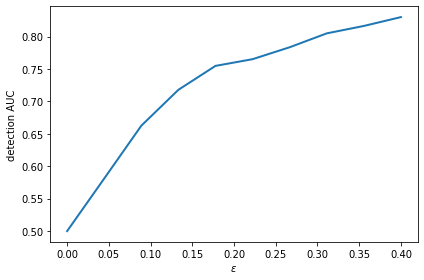

In [12]:
plt.plot(epsilons, accs, linewidth=2)
plt.xlabel("$\epsilon$")
plt.ylabel("detection AUC")
plt.tight_layout()
plt.savefig("lid.png", dpi=200, bbox_inches="tight")

In [7]:
keys = sorted(aucs.keys())
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

fig, ax1 = plt.subplots()

ax1.set_xlabel('epsilon')
ax1.set_ylabel('AUC & l_inf norm')
#plt.xscale('log')
ax1.plot(
    keys, [aucs[k] for k in keys], label="Mahalanobis"
)
ax1.plot(
    keys, [linfs[k] for k in keys], label="l_inf"
)

ax2 = ax1.twinx()
ax2.set_ylabel("l_2 norm")

ax2.plot(
    keys, [l2s[k] for k in keys], label="l_2", color="green"
)

ax1.legend()
ax2.legend()